In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/french-twitter-sentiment-analysis/french_tweets.csv


In [72]:
!pip install gradio

In [73]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import gradio as gr

In [74]:
data = pd.read_csv('/kaggle/input/french-twitter-sentiment-analysis/french_tweets.csv')

data.head()

,label,text
0,0,"- Awww, c'est un bummer. Tu devrais avoir davi..."
1,0,Est contrarié qu'il ne puisse pas mettre à jou...
2,0,J'ai plongé plusieurs fois pour la balle. A ré...
3,0,Tout mon corps a des démangeaisons et comme si...
4,0,"Non, il ne se comporte pas du tout. je suis en..."


In [75]:
print(data.info())
print(data['label'].value_counts()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526724 entries, 0 to 1526723
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   label   1526724 non-null  int64 
 1   text    1526724 non-null  object
dtypes: int64(1), object(1)
memory usage: 23.3+ MB
None
label
0    771604
1    755120
Name: count, dtype: int64


In [76]:
# Limiter à 500 000 tweets par classe
data_balanced = data.groupby('label').apply(lambda x: x.sample(n=500000, random_state=42)).reset_index(drop=True)

print(data_balanced['label'].value_counts())

/tmp/ipykernel_36/2106389185.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_balanced = data.groupby('label').apply(lambda x: x.sample(n=500000, random_state=42)).reset_index(drop=True)


label
0    500000
1    500000
Name: count, dtype: int64


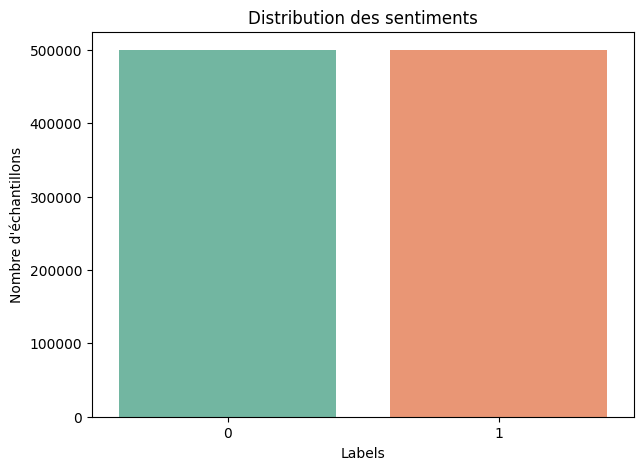

In [77]:
# Visualisation avec seaborn
plt.figure(figsize=(7,5))
sns.countplot(x='label', data=data_balanced, palette='Set2')
plt.title("Distribution des sentiments")
plt.xlabel("Labels")
plt.ylabel("Nombre d'échantillons")
plt.show()

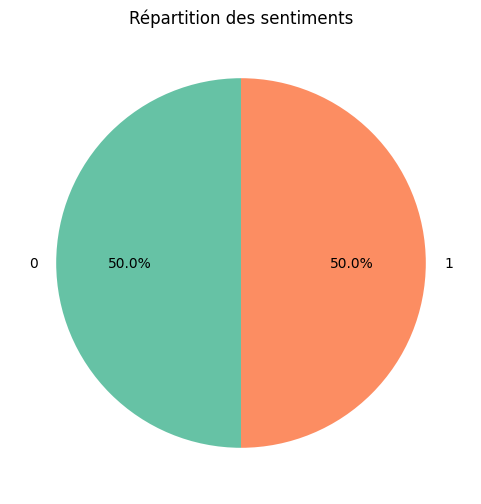

In [78]:
# Diagramme circulaire
plt.figure(figsize=(6,6))
data_balanced['label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
plt.title("Répartition des sentiments")
plt.ylabel("")  # Pour enlever le label 'label'
plt.show()

In [79]:
# Cellule pédagogique unique — nettoyage de texte pas à pas (exécution + explications)
import re
import string
import nltk
from nltk.corpus import stopwords
import pandas as pd

# --- Préparation des stopwords ---
# Téléchargement (silencieux) si nécessaire
nltk.download('stopwords', quiet=True)
try:
    stop_words = set(stopwords.words('french'))
except LookupError:
    # Si téléchargement échoue, afficher message clair
    print("Erreur: la ressource 'stopwords' de NLTK est introuvable.")
    print("Exécutez: nltk.download('stopwords') puis relancez la cellule.")
    raise

In [80]:
# Petite explication (affichée)
print("QU'EST-CE QU'UN STOPWORD ?")
print("-" * 60)
print("Un *stopword* est un mot très fréquent mais peu informatif (ex : 'et', 'la', 'de', 'un').")
print("On les retire souvent avant d'entraîner un modèle NLP pour se concentrer sur les mots porteurs de sens.")
print(f"Nombre de stopwords (français) chargés : {len(stop_words)}")
print("Exemples de stopwords :", sorted(list(stop_words))[:30])
print("\n" + "="*80 + "\n")

QU'EST-CE QU'UN STOPWORD ?
------------------------------------------------------------
Un *stopword* est un mot très fréquent mais peu informatif (ex : 'et', 'la', 'de', 'un').
On les retire souvent avant d'entraîner un modèle NLP pour se concentrer sur les mots porteurs de sens.
Nombre de stopwords (français) chargés : 157
Exemples de stopwords : ['ai', 'aie', 'aient', 'aies', 'ait', 'as', 'au', 'aura', 'aurai', 'auraient', 'aurais', 'aurait', 'auras', 'aurez', 'auriez', 'aurions', 'aurons', 'auront', 'aux', 'avaient', 'avais', 'avait', 'avec', 'avez', 'aviez', 'avions', 'avons', 'ayant', 'ayante', 'ayantes']




In [81]:
# --- Exemple de texte brut (typique d'un tweet / message) ---
exemple = "Bonjour à tous !!! Je vais vous partager un lien utile : https://exemple.com @Pierre123 😃 J'ai 2 chats et 1 chien."
print("Texte original :")
print(exemple)
print("\n" + "-"*80 + "\n")

# --- Étape 1 : suppression des mentions (@utilisateur) ---
step1 = re.sub(r'@\w+', '', exemple)
print("Étape 1 — Suppression des mentions (@utilisateur) :")
print(step1)
print("\n" + "-"*80 + "\n")

# --- Étape 2 : suppression des URLs ---
step2 = re.sub(r'http\S+|www\S+|https\S+', '', step1, flags=re.MULTILINE)
print("Étape 2 — Suppression des URLs :")
print(step2)
print("\n" + "-"*80 + "\n")

# --- Étape 3 : suppression de la ponctuation ASCII (string.punctuation) ---
step3 = step2.translate(str.maketrans('', '', string.punctuation))
print("Étape 3 — Suppression de la ponctuation (ASCII) :")
print(step3)
print("\nRemarque : certains signes unicode (ex: guillemets typographiques) peuvent rester.")
print("\n" + "-"*80 + "\n")

# --- Étape 4 : suppression des chiffres ---
step4 = re.sub(r'\d+', '', step3)
print("Étape 4 — Suppression des chiffres :")
print(step4)
print("\n" + "-"*80 + "\n")

# --- Étape 5 : conversion en minuscules ---
step5 = step4.lower()
print("Étape 5 — Conversion en minuscules :")
print(step5)
print("\n" + "-"*80 + "\n")

# --- Étape 6 : suppression des stopwords ---
tokens = step5.split()
kept_tokens = [w for w in tokens if w not in stop_words]
step6 = " ".join(kept_tokens)
print("Étape 6 — Suppression des stopwords :")
print("Tokens avant suppression :", tokens)
print("Tokens après suppression  :", kept_tokens)
print("\nTexte final nettoyé :")
print(step6)
print("\n" + "="*80 + "\n")

Texte original :
Bonjour à tous !!! Je vais vous partager un lien utile : https://exemple.com @Pierre123 😃 J'ai 2 chats et 1 chien.

--------------------------------------------------------------------------------

Étape 1 — Suppression des mentions (@utilisateur) :
Bonjour à tous !!! Je vais vous partager un lien utile : https://exemple.com  😃 J'ai 2 chats et 1 chien.

--------------------------------------------------------------------------------

Étape 2 — Suppression des URLs :
Bonjour à tous !!! Je vais vous partager un lien utile :   😃 J'ai 2 chats et 1 chien.

--------------------------------------------------------------------------------

Étape 3 — Suppression de la ponctuation (ASCII) :
Bonjour à tous  Je vais vous partager un lien utile    😃 Jai 2 chats et 1 chien

Remarque : certains signes unicode (ex: guillemets typographiques) peuvent rester.

--------------------------------------------------------------------------------

Étape 4 — Suppression des chiffres :
Bonjour à

In [82]:
# --- Fonction utilitaire finale (même pipeline, sans prints) ---
def clean_text(text, stop_words=stop_words):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = " ".join([w for w in text.split() if w not in stop_words])
    return text

In [83]:
# --- Application au DataFrame 'data' si présent, sinon démonstration sur un petit DataFrame ---
if 'data' in globals() and isinstance(data_balanced, pd.DataFrame) and 'text' in data_balanced.columns:
    # On n'écrase pas 'data' si l'utilisateur l'a déjà défini — on ajoute juste la colonne
    data_balanced['cleaned_text'] = data_balanced['text'].apply(clean_text)
    print("Application faite sur votre DataFrame 'data'. Aperçu (avant / après) :")
    display(data_balanced[['text', 'cleaned_text']].head(5))
else:
    demo = pd.DataFrame({
        'text': [
            exemple,
            "Super offre !! Visitez www.offre.com maintenant. @Store 50% OFF!!",
            "Demain 10h réunion avec le Dr. Dupont - confirmez svp."
        ]
    })
    demo['cleaned_text'] = demo['text'].apply(clean_text)
    print("Aucun DataFrame 'data' trouvé — démonstration sur un petit DataFrame 'demo' :")
    display(demo)

Application faite sur votre DataFrame 'data'. Aperçu (avant / après) :


,text,cleaned_text
0,"Non, je ne la regarde pas, idk elle.",non regarde idk
1,"- Très, très vrai.",très très vrai
2,Allongé au lit et essayant de dormir ne se pas...,allongé lit essayant dormir passe dois être he...
3,"S'endormir, rêver à propos de Tom et un amour ...",sendormir rêver propos tom amour jamais lt bye...
4,"Avoir eu des problèmes majeurs avec la santé, ...",avoir problèmes majeurs santé tension artériel...


In [84]:
# Diviser tous les textes nettoyés en mots individuels
all_words = " ".join(data_balanced['cleaned_text']).split()

# Créer un ensemble pour obtenir les mots uniques
unique_words = set(all_words)

# Compter les mots uniques
vocab_size = len(unique_words)

print(f"Le vocabulaire contient {vocab_size} mots uniques après nettoyage.")

Le vocabulaire contient 217530 mots uniques après nettoyage.


In [85]:
from collections import Counter

# Compter la fréquence de chaque mot
word_counts = Counter(all_words)

# Obtenir les 10 mots les plus fréquents
most_common_words = word_counts.most_common(10)

print("Les 10 mots les plus fréquents :")
for word, count in most_common_words:
    print(f"{word}: {count}")

Les 10 mots les plus fréquents :
jai: 110981
a: 88144
cest: 74530
plus: 59996
si: 53883
bien: 52093
maintenant: 51752
faire: 48886
tout: 45625
aujourdhui: 42256


In [86]:
# Tokeniser chaque tweet en une liste de mots
data_balanced['tokenized_text'] = data_balanced['cleaned_text'].apply(lambda x: x.split())

In [87]:
import gensim.downloader as api
import numpy as np

# Charger GloVe pré-entraîné
glove_model = api.load("glove-wiki-gigaword-100")  # vecteurs 100-dim, comme ton Word2Vec

def sentence_to_vec(tokens, model, vector_size=100):
    """
    Convertit une liste de tokens en vecteur moyen GloVe.
    """
    vecs = []
    for token in tokens:
        if token in model:
            vecs.append(model[token])
    if len(vecs) > 0:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(vector_size)

# Appliquer à tout le dataset
data_balanced['glove_vector'] = data_balanced['tokenized_text'].apply(lambda x: sentence_to_vec(x, glove_model))

In [88]:
import pickle

# Sauvegarder
with open("glove_vectors.pkl", "wb") as f:
    pickle.dump(data_balanced['glove_vector'].tolist(), f)

print("Embeddings sauvegardés dans 'glove_vectors.pkl'")

# Pour recharger plus tard
with open("glove_vectors.pkl", "rb") as f:
    loaded_vectors = pickle.load(f)

Embeddings sauvegardés dans 'glove_vectors.pkl'


In [89]:
import numpy as np
import gensim.downloader as api

# Charger le modèle GloVe pré-entraîné
glove_model = api.load("glove-wiki-gigaword-100")  # vecteurs 100-dim

vector_size = 100  # correspond à la dimension de GloVe

def get_tweet_embedding_glove(tweet, model, vector_size):
    # Calculer la moyenne des vecteurs des mots présents dans le tweet
    vectors = [model[word] for word in tweet if word in model]
    if len(vectors) == 0:  # aucun mot trouvé
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Appliquer à chaque tweet
data_balanced['embedding'] = data_balanced['tokenized_text'].apply(
    lambda x: get_tweet_embedding_glove(x, glove_model, vector_size)
)

# Créer les tableaux numpy pour features et labels
X = np.array(data_balanced['embedding'].tolist())
y = data_balanced['label']

print("Taille de X :", X.shape)
print("Taille de y :", y.shape)

Taille de X : (1000000, 100)
Taille de y : (1000000,)


In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Forme des données d'entraînement:", X_train.shape)
print("Forme des données de test:", X_test.shape)

Forme des données d'entraînement: (800000, 100)
Forme des données de test: (200000, 100)


In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Construire un réseau de neurones simple
model = Sequential([
    Dense(128, activation='relu', input_shape=(vector_size,)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sortie binaire pour la classification
])

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.6097 - loss: 0.6521 - val_accuracy: 0.6481 - val_loss: 0.6215
Epoch 2/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.6394 - loss: 0.6290 - val_accuracy: 0.6555 - val_loss: 0.6152
Epoch 3/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.6451 - loss: 0.6239 - val_accuracy: 0.6577 - val_loss: 0.6131
Epoch 4/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.6473 - loss: 0.6222 - val_accuracy: 0.6580 - val_loss: 0.6123
Epoch 5/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.6497 - loss: 0.6198 - val_accuracy: 0.6590 - val_loss: 0.6110
Epoch 6/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.6512 - loss: 0.6192 - val_accuracy: 0.6605 - val_loss: 0.6099
Epoch 7/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.6516 - loss: 0.6179 - val_accuracy: 0.6618 - val_loss: 0.6101
Epoch 8/10
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
              precision    recall  f1-score   support

           0       0.69      0.61      0.64     99987
           1       0.65      0.72      0.68    100013

    accuracy                           0.66    200000
   macro avg       0.67      0.66      0.66    200000
weighted avg       0.67      0.66      0.66    200000



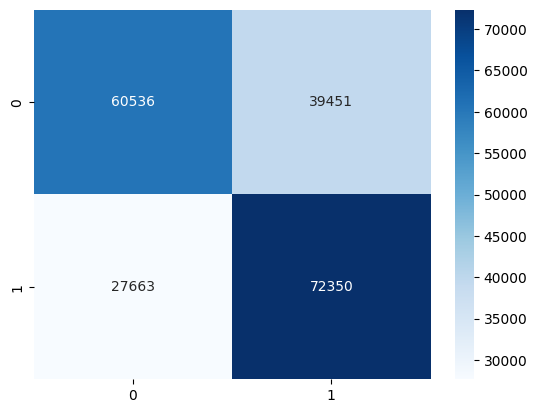

In [92]:
# Évaluer les performances sur le jeu de test
y_pred = (model.predict(X_test) > 0.5).astype("int32")

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))

# Afficher la matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

In [94]:
import gradio as gr
import numpy as np

# Fonction pour générer l'embedding avec GloVe
def get_tweet_embedding_glove(tweet, model, vector_size=100):
    vectors = [model[word] for word in tweet if word in model]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Fonction de prédiction pour Gradio
def predict_sentiment_with_glove(text):
    # Nettoyer et tokeniser
    cleaned_text = clean_text(text)
    tokenized_text = cleaned_text.split()
    # Générer l'embedding GloVe
    embedding = get_tweet_embedding_glove(tokenized_text, glove_model, vector_size).reshape(1, -1)
    # Prédire
    prediction = model.predict(embedding)
    return "Positif" if prediction[0] > 0.5 else "Négatif"

# Interface Gradio
interface = gr.Interface(
    fn=predict_sentiment_with_glove,
    inputs=gr.Textbox(label="Entrez un tweet en français"),
    outputs=gr.Label(label="Sentiment"),
    title="Analyse de Sentiment avec Embeddings GloVe",
    description="Ce modèle utilise des embeddings GloVe pour prédire le sentiment des tweets."
)

# Lancer l'interface
interface.launch()

* Running on local URL:  http://127.0.0.1:7861
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://d0ac3343a66f064826.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
